In [1]:
import funcs
import mrsobs

import os
import itertools
import numpy as np
from astropy.io import fits
from scipy.stats import norm
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [11]:
workDir  = '/Users/ioannisa/Desktop/python/miri_devel/'
d2cMapDir = workDir+'notebooks/distortionMaps/'
cdpDir   = workDir+'cdp_data/'
lvl1path = workDir+'CV3_data/LVL1/'
lvl2path = workDir+'CV3_data/LVL2/'

band   = '2A'
infile_PixelToPixelMap = 'NonLinearityCorrection_OutputParameters_dic_CV3_MRS_RAD_14'

In [12]:
nl_coefficients_PixelToPixelMap = funcs.load_obj(infile_PixelToPixelMap,path='obj/')[band]

# CDP8
subchan_names = {'A':'SHORT','B':'MEDIUM','C':'LONG'}
if int(band[0]) < 3: detnick = 'MIRIFUSHORT'
else: detnick = 'MIRIFULONG'
if int(band[0]) < 3: photom_subchan_name = '12'
else: photom_subchan_name = '34'
nonlinearity_file = os.path.join(cdpDir+'CDP8/',\
  'MIRI_FM_%s_%s%s_LINEARITY_8B.02.00.fits' % (detnick,photom_subchan_name,subchan_names[band[1]]))
nl_coefficients_CDP8 = fits.open(nonlinearity_file)[1].data

In [13]:
d2cMaps = funcs.load_obj('d2cMaps_band{}_tr90pc'.format(band),path=d2cMapDir)
sel = (d2cMaps['sliceMap'] > 100*int(band[0])) & (d2cMaps['sliceMap'] < 100*(int(band[0])+1) )

In [14]:
# The non-linearity correction is described by a n-th order polynomial, define the order here, as well as the integration ramp to be used
order = 4
analyze_ramp = 1

# define frames in ramp to skip
skip_first = 3
skip_last  = 1

In [15]:
# Reference dataset
# CV3 MIRM108 (MRS_RAD_14, ramps purposed for non-linearity correction)
filename1 = mrsobs.MIRI_internal_calibration_source_nonlinearity_correction(lvl1path,band,output='filename').replace('_LVL2','')

# Second dataset
# CV3 MIRM33541 (MRS_RAD_11, observations of internal calibration source in nominal and cross-dichroic configurations)
filename2 = mrsobs.MIRI_internal_calibration_source(lvl1path,band,campaign='CV3',output='filename').replace('_LVL2','')

# lvl1path_new = '/STER/miriman/FM/'
# filename2 = mrsobs.MIRI_internal_calibration_source(lvl1path_new,band,campaign='FM',output='filename').replace('_LVL2','')
# filename2 = mrsobs.FM_MTS_BB_extended_source(lvl1path_new,band,bb_temp='800K',output='filename')[0].replace('_LVL2','')
# filename2 = mrsobs.MIRI_high_background(lvl1path_new,band,output='filename').replace('_LVL2','')
# filename2 = mrsobs.FM_MTS_800K_BB_extended_source_through_etalon(lvl1path_new,band,etalon='ET1A',output='filename')[0].replace('_LVL2','')
# filename2 = workDir+'OTIS_data/LVL1/MIRM32313-SS-V03-7249024654_1_495_SE_2017-09-06T02h54m21.fits'

print filename1
image_hdu1 = fits.open(filename1)
image_data1 = fits.getdata(filename1)[:,:1024,:].astype('float')

print filename2
image_hdu2 = fits.open(filename2)
image_data2 = fits.getdata(filename2)[:,:1024,:].astype('float')

/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM108-SHORT-6021192005_1_495_SE_2016-01-21T20h36m13.fits
/Users/ioannisa/Desktop/python/miri_devel/CV3_data/LVL1/MIRM33541-A-A-8MA-6019093539_1_495_SE_2016-01-19T09h59m18.fits


In [16]:
image_shape1 = image_data1.shape
nints1       = image_hdu1[0].header['NINT']
ngroups1     = image_hdu1[0].header['NGROUP']
nframes1     = image_shape1[0]
readout1     = image_hdu1[0].header['READOUT']
frame_delta_time1 = image_hdu1[0].header['TFRAME']
print('Number of integrations: {}'.format(nints1))
print('Number of groups/frames per integration: {}'.format(ngroups1))
print('Total number of frames: {}'.format(nframes1))
print('Readout: {}'.format(readout1))
print('Time between samples: {} sec'.format(frame_delta_time1))
print('LVL1 data shape: {}'.format(image_shape1))
print('')

image_shape2 = image_data2.shape
nints2       = image_hdu2[0].header['NINT']
ngroups2     = image_hdu2[0].header['NGROUP']
nframes2     = image_shape2[0]
readout2     = image_hdu2[0].header['READOUT']
frame_delta_time2 = image_hdu2[0].header['TFRAME']
print('Number of integrations: {}'.format(nints2))
print('Number of groups/frames per integration: {}'.format(ngroups2))
print('Total number of frames: {}'.format(nframes2))
print('Readout: {}'.format(readout2))
print('Time between samples: {} sec'.format(frame_delta_time2))
print('LVL1 data shape: {}'.format(image_shape2))

Number of integrations: 6
Number of groups/frames per integration: 60
Total number of frames: 360
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (360, 1024, 1032)

Number of integrations: 5
Number of groups/frames per integration: 20
Total number of frames: 100
Readout: FAST
Time between samples: 2.77504 sec
LVL1 data shape: (100, 1024, 1032)


In [17]:
image_hdu1.close()
image_hdu2.close()

<IPython.core.display.Javascript object>


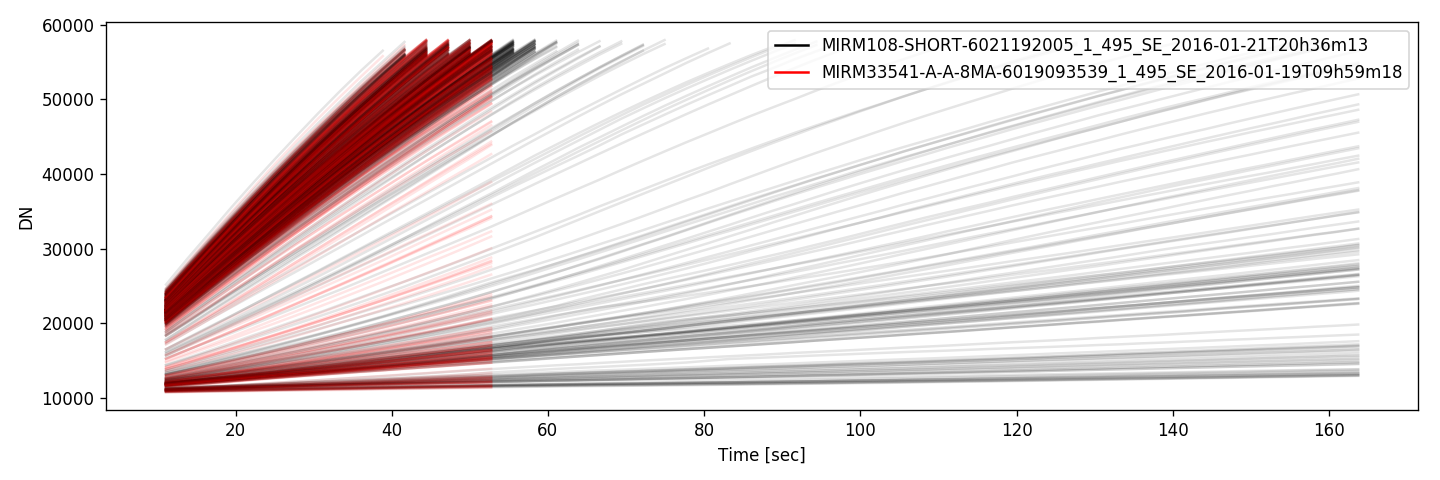

In [18]:
plt.close('all')

if band[0] in ['1','4']:
    range_x = range(10,512)
elif band[0] in ['2','3']:
    range_x = range(512,1020)

plt.figure(figsize=(12,4))
for ypos in [10]:
    for xpos in range_x:
        time  = np.arange(1,nframes1+1)[(analyze_ramp-1)*ngroups1:analyze_ramp*ngroups1]*frame_delta_time1
        tramp = image_data1[(analyze_ramp-1)*ngroups1:analyze_ramp*ngroups1,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
        plt.plot(time3,tramp3,'k',alpha=0.1)
        
        time  = np.arange(1,nframes2+1)[(analyze_ramp-1)*ngroups2:analyze_ramp*ngroups2]*frame_delta_time2
        tramp = image_data2[(analyze_ramp-1)*ngroups2:analyze_ramp*ngroups2,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]
        plt.plot(time3,tramp3,'r',alpha=0.1)
legend_elements = [Line2D([0],[0],color='k',label=filename1.split('/')[-1].split('.fits')[0]),
                   Line2D([0],[0],color='r',label=filename2.split('/')[-1].split('.fits')[0])]
plt.legend(handles=legend_elements)
plt.xlabel('Time [sec]')
plt.ylabel('DN')
plt.tight_layout()

In [19]:
plt.close('all')

## Derive non-linearity corrected relevant parameters for full MRS detector

<IPython.core.display.Javascript object>


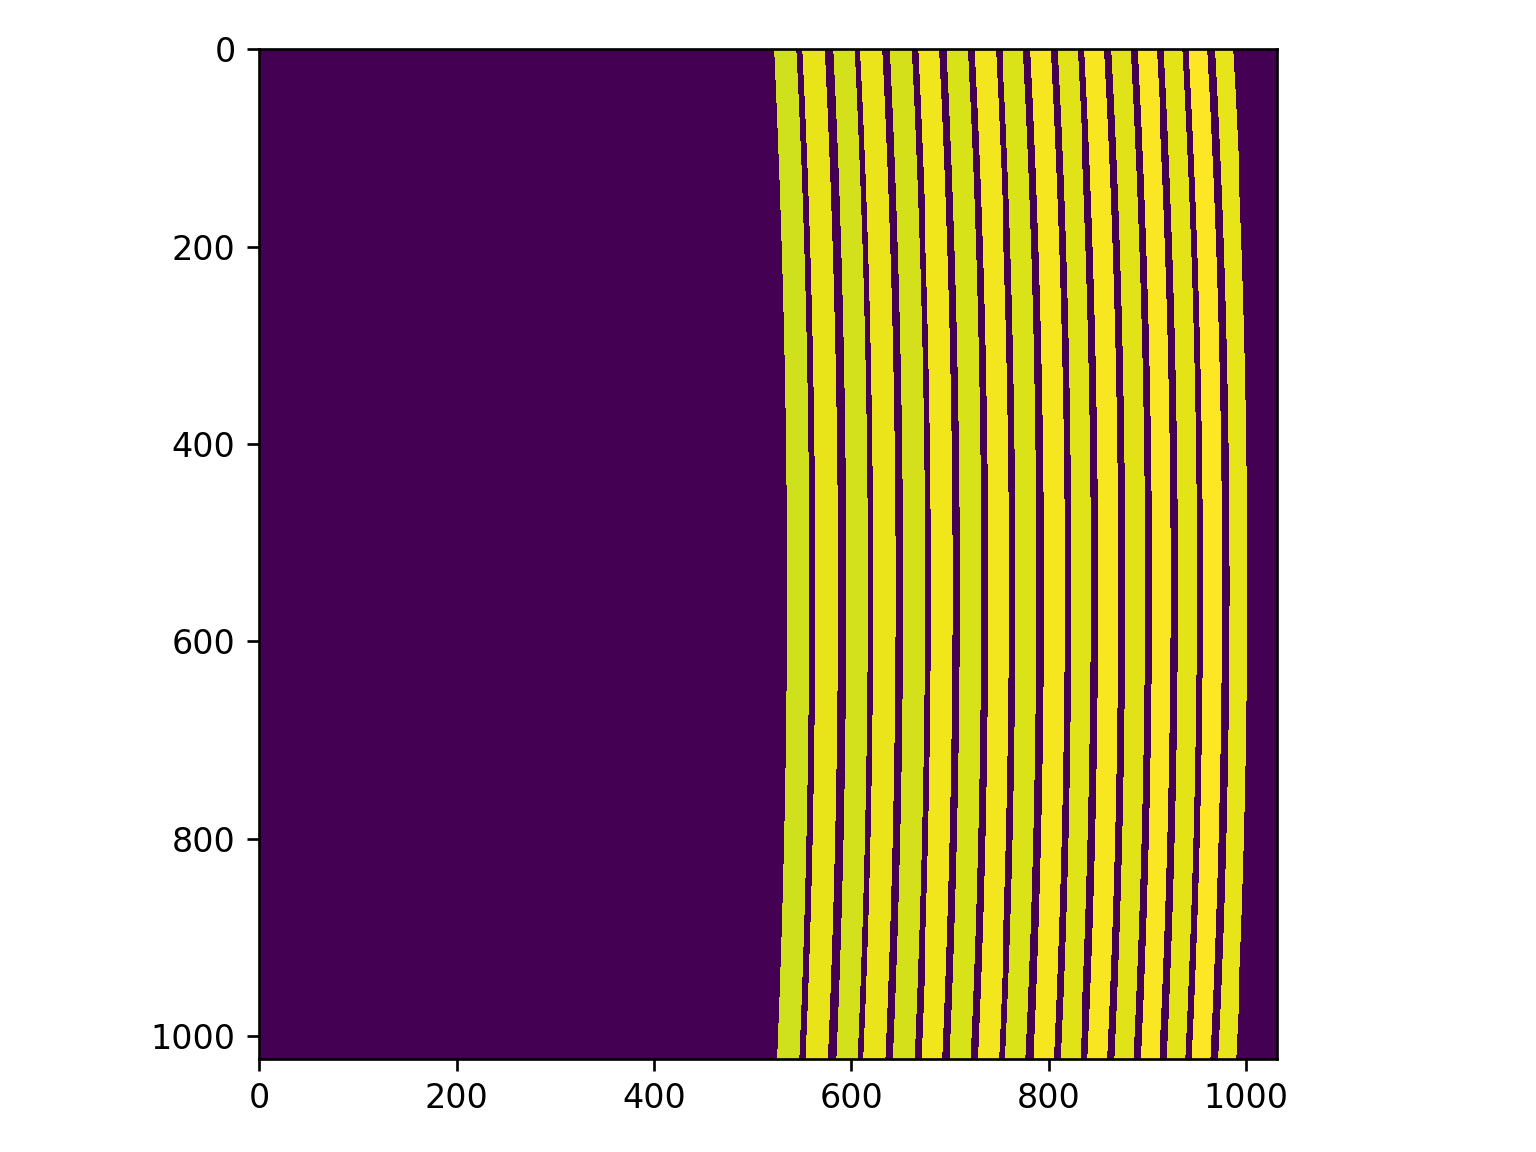

In [20]:
# pixels investigated
slice_img = d2cMaps['sliceMap']
if band[0] in ['1','4']:
    slice_img[:,516:] = 0
elif band[0] in ['2','3']:
    slice_img[:,:516] = 0

funcs.implot(slice_img)

In [21]:
#-- Reference dataset
# initialize placeholders
std_pixelTopixelCorr_1 = np.zeros(shape =(image_shape1[1], image_shape1[2] ), dtype=np.float64)
std_CDP8_1 = np.zeros(shape =(image_shape1[1], image_shape1[2] ), dtype=np.float64)
slope_pixelTopixelCorr_1 = np.zeros(shape =(image_shape1[1], image_shape1[2] ), dtype=np.float64)
slope_CDP8_1 = np.zeros(shape =(image_shape1[1], image_shape1[2] ), dtype=np.float64)

for ypos,xpos in itertools.product(range(1024),range(1032)):
    if (xpos==511) & (ypos%100 == 0):
        print 'Row {}'.format(ypos)
    if slice_img[ypos,xpos] == 0:
        continue
    elif slice_img[ypos,xpos] != 0:
        time  = np.arange(1,nframes1+1)[(analyze_ramp-1)*ngroups1:analyze_ramp*ngroups1]*frame_delta_time1
        if analyze_ramp != 1:
            time = time-time[0]+frame_delta_time1
        tramp = image_data1[(analyze_ramp-1)*ngroups1:analyze_ramp*ngroups1,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

        # derive non-linearity correction
        intime = time3
        inramp = tramp3

        #solve for the correction factor as a function of observed DN.
        cor_factor_PixelToPixelMap = np.polynomial.polynomial.polyval(inramp, nl_coefficients_PixelToPixelMap[:, ypos, xpos])
        cor_factor_CDP8 = np.polynomial.polynomial.polyval(inramp, nl_coefficients_CDP8[:, ypos, xpos])

        # correct ramp by applying derived NL correction
        corrected_ramp_PixelToPixelMap = cor_factor_PixelToPixelMap * inramp
        corrected_ramp_CDP8 = cor_factor_CDP8 * inramp

        std_pixelToPixelCorr = np.std((np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time1)-np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time1) )
        std_CDP8Corr = np.std((np.diff(corrected_ramp_CDP8)/frame_delta_time1)-np.mean(np.diff(corrected_ramp_CDP8)/frame_delta_time1) )

        # insert results in placeholder array
        std_pixelTopixelCorr_1[ypos,xpos] = std_pixelToPixelCorr
        std_CDP8_1[ypos,xpos] = std_CDP8Corr
        slope_pixelTopixelCorr_1[ypos,xpos] = np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time1)
        slope_CDP8_1[ypos,xpos] = np.mean(np.diff(corrected_ramp_CDP8)/frame_delta_time1)

Row 0
Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


In [22]:
#-- Second dataset
std_pixelTopixelCorr_2 = np.zeros(shape =(image_shape2[1], image_shape2[2] ), dtype=np.float64)
std_CDP8_2 = np.zeros(shape =(image_shape2[1], image_shape2[2] ), dtype=np.float64)
slope_pixelTopixelCorr_2 = np.zeros(shape =(image_shape2[1], image_shape2[2] ), dtype=np.float64)
slope_CDP8_2 = np.zeros(shape =(image_shape2[1], image_shape2[2] ), dtype=np.float64)

for ypos,xpos in itertools.product(range(1024),range(1032)):
    if (xpos==511) & (ypos%100 == 0):
        print 'Row {}'.format(ypos)
    if slice_img[ypos,xpos] == 0:
        continue
    elif slice_img[ypos,xpos] != 0:
        time  = np.arange(1,nframes2+1)[(analyze_ramp-1)*ngroups2:analyze_ramp*ngroups2]*frame_delta_time2
        if analyze_ramp != 1:
            time = time-time[0]+frame_delta_time2
        tramp = image_data2[(analyze_ramp-1)*ngroups2:analyze_ramp*ngroups2,ypos,xpos]
        time2,tramp2 = time[skip_first:-skip_last],tramp[skip_first:-skip_last]
        time3,tramp3 = time2[tramp2 < 58000],tramp2[tramp2 < 58000]

        # derive non-linearity correction
        intime = time3
        inramp = tramp3

        #solve for the correction factor as a function of observed DN.
        cor_factor_PixelToPixelMap = np.polynomial.polynomial.polyval(inramp, nl_coefficients_PixelToPixelMap[:, ypos, xpos])
        cor_factor_CDP8 = np.polynomial.polynomial.polyval(inramp, nl_coefficients_CDP8[:, ypos, xpos])

        # correct ramp by applying derived NL correction
        corrected_ramp_PixelToPixelMap = cor_factor_PixelToPixelMap * inramp
        corrected_ramp_CDP8 = cor_factor_CDP8 * inramp

        std_pixelToPixelCorr = np.std((np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time2)-np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time2) )
        std_CDP8Corr = np.std((np.diff(corrected_ramp_CDP8)/frame_delta_time2)-np.mean(np.diff(corrected_ramp_CDP8)/frame_delta_time2) )

        # insert results in placeholder array
        std_pixelTopixelCorr_2[ypos,xpos] = std_pixelToPixelCorr
        std_CDP8_2[ypos,xpos] = std_CDP8Corr
        slope_pixelTopixelCorr_2[ypos,xpos] = np.mean(np.diff(corrected_ramp_PixelToPixelMap)/frame_delta_time2)
        slope_CDP8_2[ypos,xpos] = np.mean(np.diff(corrected_ramp_CDP8)/frame_delta_time2)

Row 0
Row 100
Row 200
Row 300
Row 400
Row 500
Row 600
Row 700
Row 800
Row 900
Row 1000


### Compute histograms of residual gradient for CDP8 and PixelToPixel correction

<IPython.core.display.Javascript object>


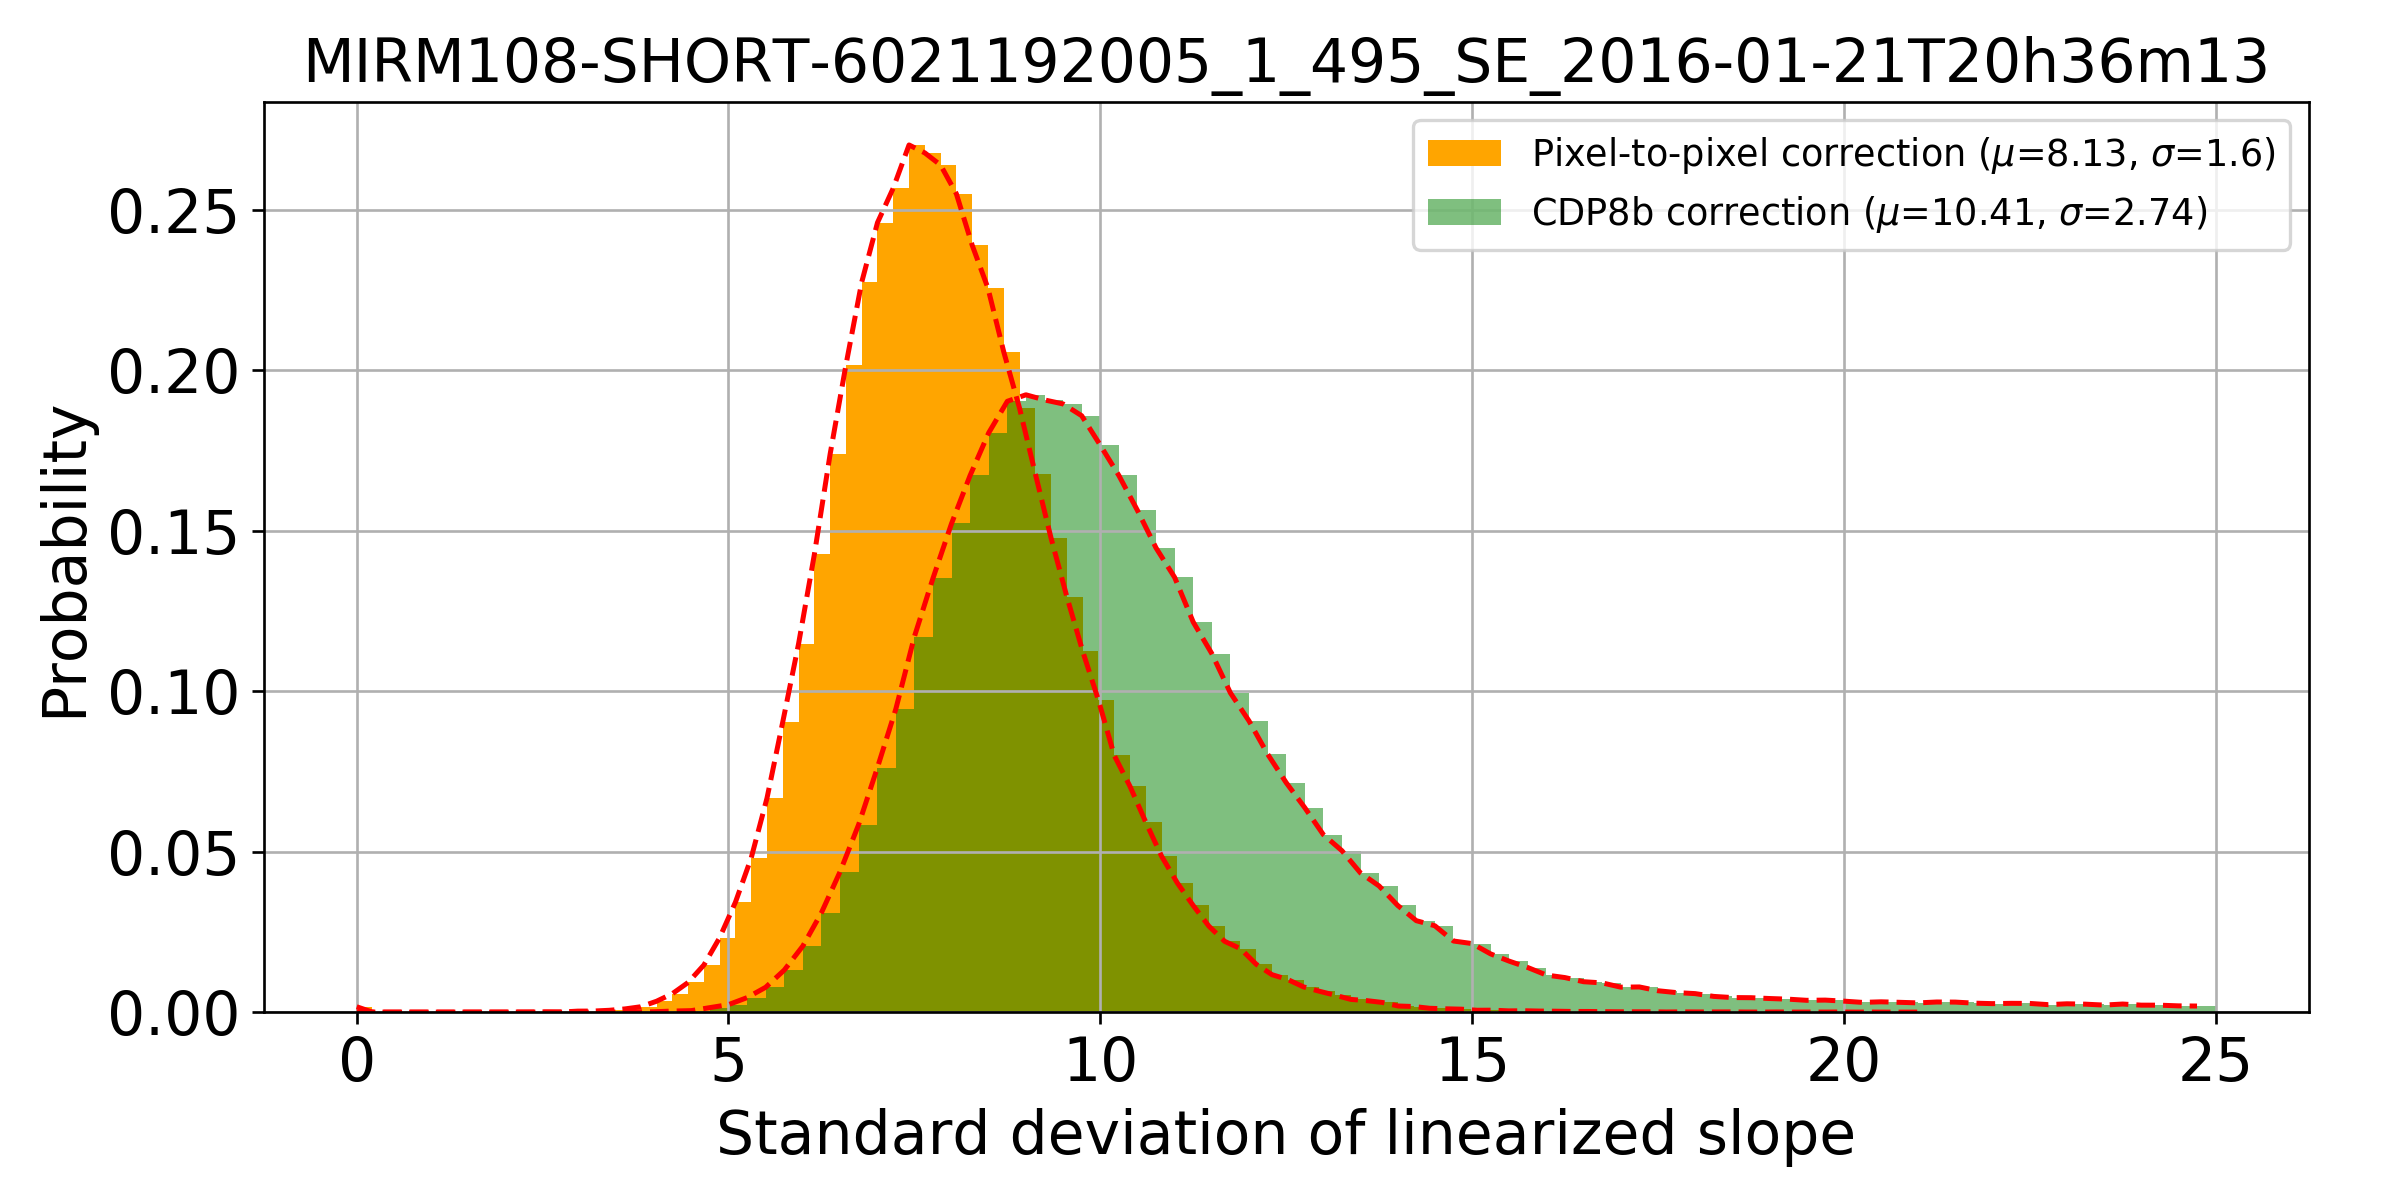

<IPython.core.display.Javascript object>


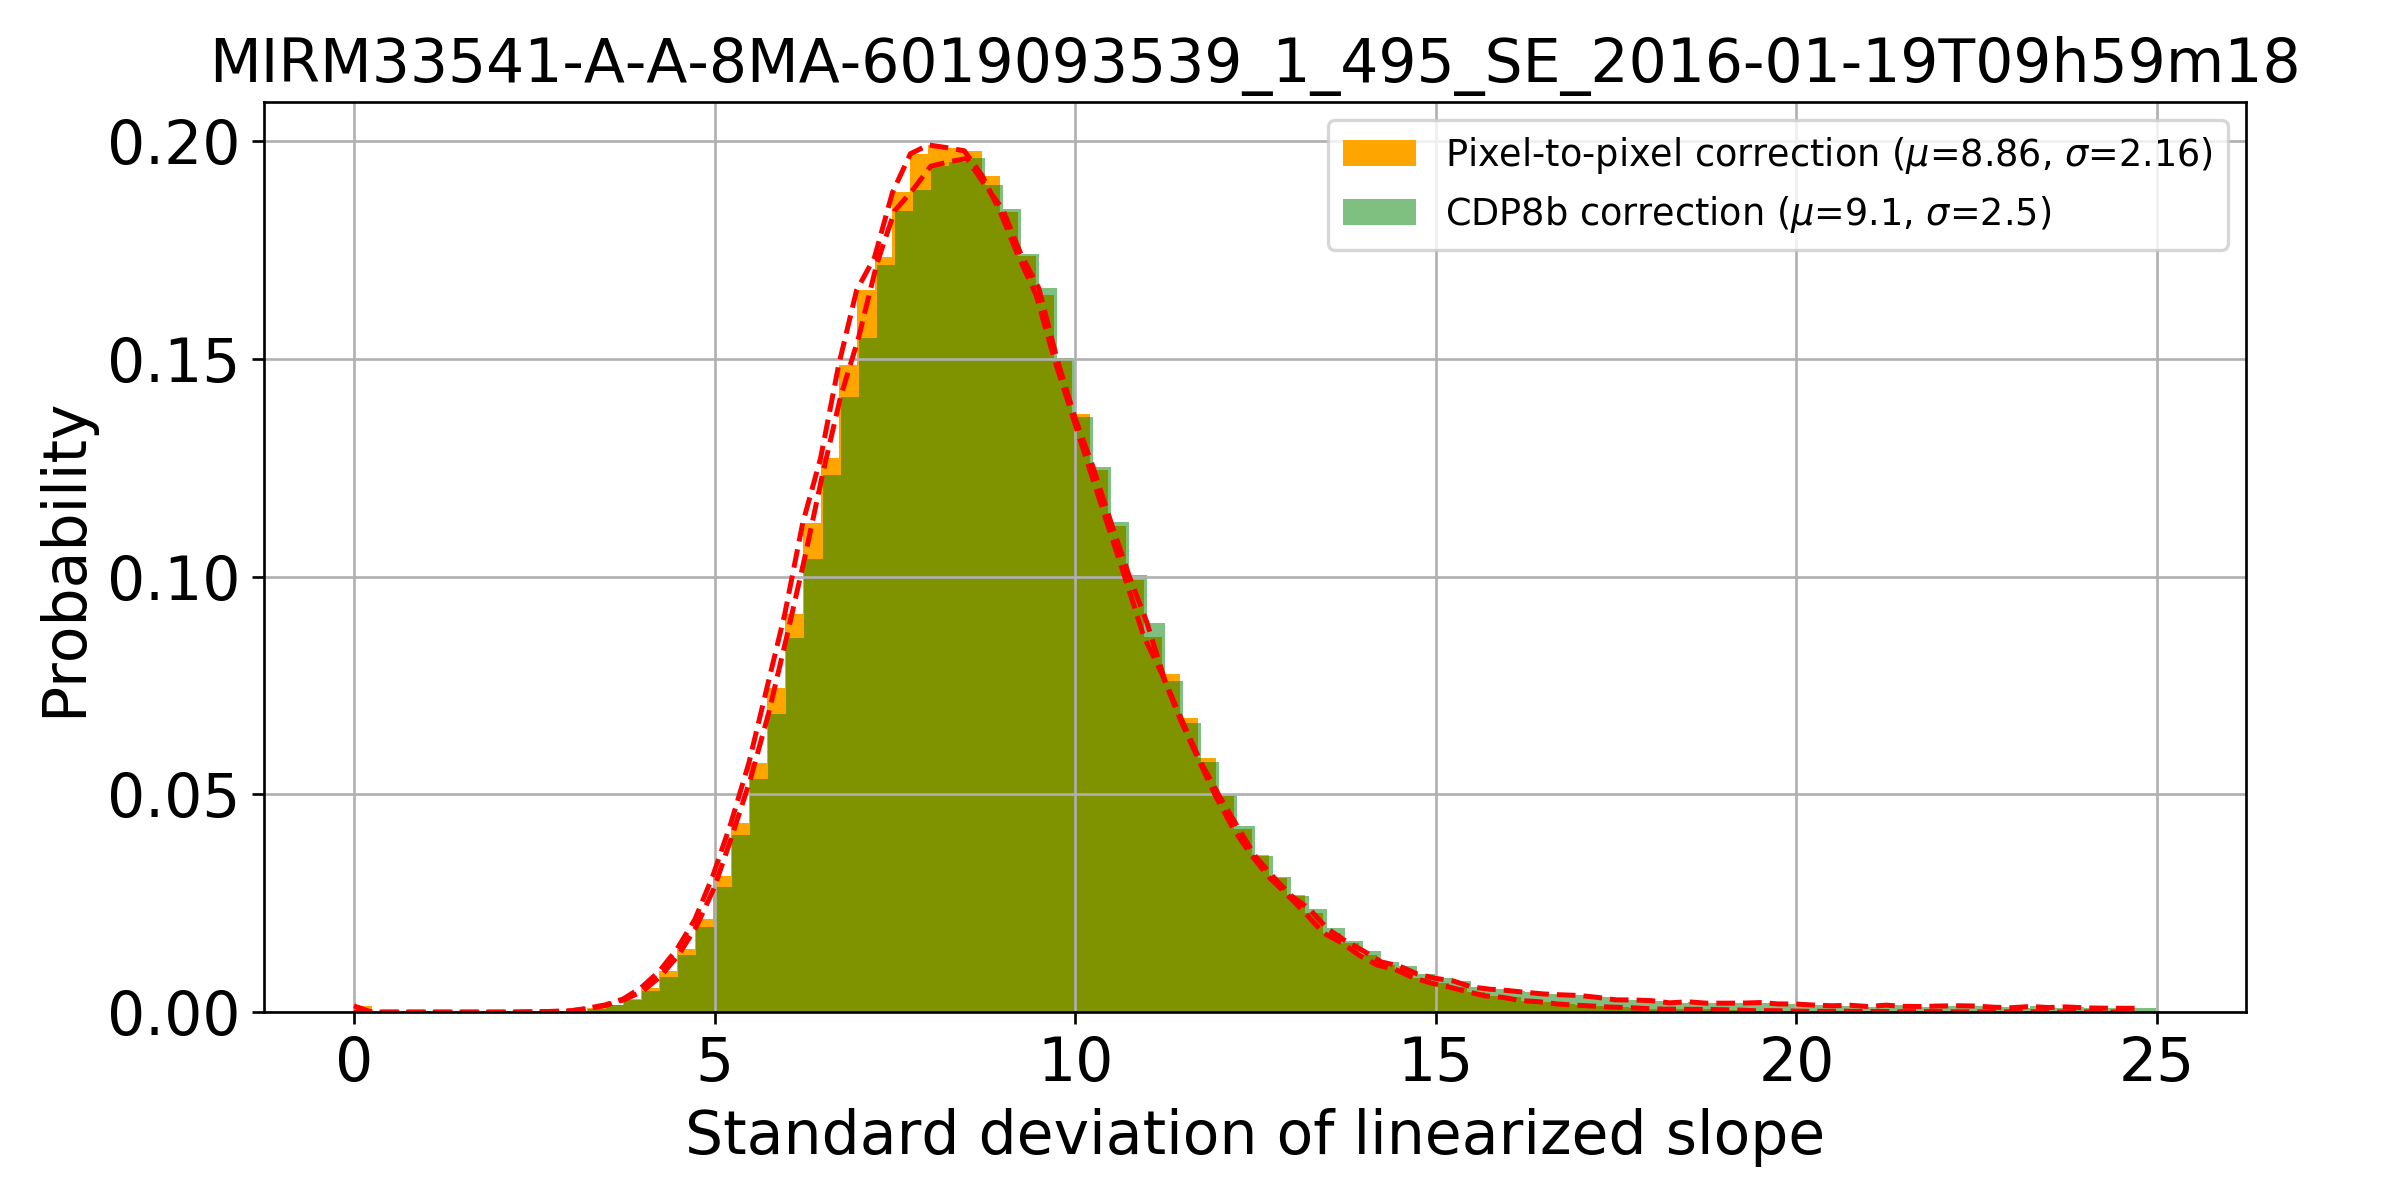

In [23]:
# Reference dataset
lower,upper = -15,25
(mu_pixelTopixelCorr, sigma_pixelTopixelCorr) = norm.fit(std_pixelTopixelCorr_1[sel][(std_pixelTopixelCorr_1[sel]>lower) & (std_pixelTopixelCorr_1[sel]<upper)])
(mu_CDP8, sigma_CDP8) = norm.fit(std_CDP8_1[sel][(std_CDP8_1[sel]>lower) & (std_CDP8_1[sel]<upper)])

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(std_pixelTopixelCorr_1[sel][(std_pixelTopixelCorr_1[sel]>lower) & (std_pixelTopixelCorr_1[sel]<upper)], 100, normed=1, facecolor='orange', alpha=1,label='Pixel-to-pixel correction ($\mu$={}, $\sigma$={})'.format(round(mu_pixelTopixelCorr,2),round(sigma_pixelTopixelCorr,2)))
y = mlab.normpdf(bins, mu_pixelTopixelCorr, sigma_pixelTopixelCorr)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(std_CDP8_1[sel][(std_CDP8_1[sel]>lower) & (std_CDP8_1[sel]<upper)], 100, normed=1, facecolor='g', alpha=0.5,label=r'CDP8b correction ($\mu$={}, $\sigma$={})'.format(round(mu_CDP8,2),round(sigma_CDP8,2)) )
y = mlab.normpdf(bins, mu_CDP8, sigma_CDP8)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
plt.xlabel('Standard deviation of linearized slope',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.tick_params(axis='both',labelsize=18)
plt.legend(fontsize=11)
plt.grid(True)
plt.title(filename1.split('/')[-1].split('.fits')[0],fontsize=18)
plt.tight_layout()

# Second dataset
lower,upper = -15,25
(mu_pixelTopixelCorr, sigma_pixelTopixelCorr) = norm.fit(std_pixelTopixelCorr_2[sel][(std_pixelTopixelCorr_2[sel]>lower) & (std_pixelTopixelCorr_2[sel]<upper)])
(mu_CDP8, sigma_CDP8) = norm.fit(std_CDP8_2[sel][(std_CDP8_2[sel]>lower) & (std_CDP8_2[sel]<upper)])

plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(std_pixelTopixelCorr_2[sel][(std_pixelTopixelCorr_2[sel]>lower) & (std_pixelTopixelCorr_2[sel]<upper)], 100, normed=1, facecolor='orange', alpha=1,label='Pixel-to-pixel correction ($\mu$={}, $\sigma$={})'.format(round(mu_pixelTopixelCorr,2),round(sigma_pixelTopixelCorr,2)))
y = mlab.normpdf(bins, mu_pixelTopixelCorr, sigma_pixelTopixelCorr)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(std_CDP8_2[sel][(std_CDP8_2[sel]>lower) & (std_CDP8_2[sel]<upper)], 100, normed=1, facecolor='g', alpha=0.5,label=r'CDP8b correction ($\mu$={}, $\sigma$={})'.format(round(mu_CDP8,2),round(sigma_CDP8,2)) )
y = mlab.normpdf(bins, mu_CDP8, sigma_CDP8)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
plt.xlabel('Standard deviation of linearized slope',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.tick_params(axis='both',labelsize=18)
plt.legend(fontsize=11)
plt.grid(True)
plt.title(filename2.split('/')[-1].split('.fits')[0],fontsize=18)
plt.tight_layout()

In [ ]:
# plot all histograms on same figure
plt.figure(figsize=(10,5))
# Reference dataset
lower,upper = -15,25
(mu_pixelTopixelCorr, sigma_pixelTopixelCorr) = norm.fit(std_pixelTopixelCorr_1[sel][(std_pixelTopixelCorr_1[sel]>lower) & (std_pixelTopixelCorr_1[sel]<upper)])
(mu_CDP8, sigma_CDP8) = norm.fit(std_CDP8_1[sel][(std_CDP8_1[sel]>lower) & (std_CDP8_1[sel]<upper)])


n, bins, patches = plt.hist(std_pixelTopixelCorr_1[sel][(std_pixelTopixelCorr_1[sel]>lower) & (std_pixelTopixelCorr_1[sel]<upper)], 100, normed=1, facecolor='orange', alpha=1,label='Pixel-to-pixel correction ($\mu$={}, $\sigma$={})'.format(round(mu_pixelTopixelCorr,2),round(sigma_pixelTopixelCorr,2)))
y = mlab.normpdf(bins, mu_pixelTopixelCorr, sigma_pixelTopixelCorr)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(std_CDP8_1[sel][(std_CDP8_1[sel]>lower) & (std_CDP8_1[sel]<upper)], 100, normed=1, facecolor='g', alpha=0.5,label=r'CDP8b correction ($\mu$={}, $\sigma$={})'.format(round(mu_CDP8,2),round(sigma_CDP8,2)) )
y = mlab.normpdf(bins, mu_CDP8, sigma_CDP8)
plt.plot(bins[:-1],n,'r',linestyle='dashed')

# Second dataset
lower,upper = -15,25
(mu_pixelTopixelCorr, sigma_pixelTopixelCorr) = norm.fit(std_pixelTopixelCorr_2[sel][(std_pixelTopixelCorr_2[sel]>lower) & (std_pixelTopixelCorr_2[sel]<upper)])
(mu_CDP8, sigma_CDP8) = norm.fit(std_CDP8_2[sel][(std_CDP8_2[sel]>lower) & (std_CDP8_2[sel]<upper)])

n, bins, patches = plt.hist(std_pixelTopixelCorr_2[sel][(std_pixelTopixelCorr_2[sel]>lower) & (std_pixelTopixelCorr_2[sel]<upper)], 100, normed=1, facecolor='cyan', alpha=1,label='Pixel-to-pixel correction ($\mu$={}, $\sigma$={})'.format(round(mu_pixelTopixelCorr,2),round(sigma_pixelTopixelCorr,2)))
y = mlab.normpdf(bins, mu_pixelTopixelCorr, sigma_pixelTopixelCorr)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
n, bins, patches = plt.hist(std_CDP8_2[sel][(std_CDP8_2[sel]>lower) & (std_CDP8_2[sel]<upper)], 100, normed=1, facecolor='grey', alpha=0.5,label=r'CDP8b correction ($\mu$={}, $\sigma$={})'.format(round(mu_CDP8,2),round(sigma_CDP8,2)) )
y = mlab.normpdf(bins, mu_CDP8, sigma_CDP8)
plt.plot(bins[:-1],n,'r',linestyle='dashed')
plt.xlabel('Standard deviation of linearized slope',fontsize=18)
plt.ylabel('Probability',fontsize=18)
plt.tick_params(axis='both',labelsize=18)
plt.legend(fontsize=11)
plt.grid(True)
plt.tight_layout()